<a href="https://colab.research.google.com/github/PederRonning/SOK3022/blob/main/CPI_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
%pip install pyjstat

In [84]:
import pandas as pd
from pyjstat import pyjstat
import requests
import matplotlib.pyplot as plt
import numpy as np

# KPI
POST_URL = 'https://data.ssb.no/api/v0/no/table/08981'

payload = {
  "query": [
    {
      "code": "Maaned",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

resultat = requests.post(POST_URL, json = payload)
# Resultat gir bare http statuskode - 200 hvis OK. Body ligger i resultat.text
print(resultat)

dataset = pyjstat.Dataset.read(resultat.text)
df = dataset.write('dataframe')
#df = df[['år', 'value']]
#df.set_index('år', inplace=True)

<Response [200]>


In [85]:
#df['år'] = pd.to_datetime(df['år'], format='%Y')
# Map Norwegian month names to month numbers
month_mapping = {
    'Januar': 1,
    'Februar': 2,
    'Mars': 3,
    'April': 4,
    'Mai': 5,
    'Juni': 6,
    'Juli': 7,
    'August': 8,
    'September': 9,
    'Oktober': 10,
    'November': 11,
    'Desember': 12
}
df['måned'] = df['måned'].map(month_mapping)  # Apply mapping

# remove NA
df = df.dropna()

In [86]:
df

,måned,statistikkvariabel,år,value
1,1,Konsumprisindeks (2015=100),1921,5.7
2,1,Konsumprisindeks (2015=100),1922,4.6
3,1,Konsumprisindeks (2015=100),1923,4.0
4,1,Konsumprisindeks (2015=100),1924,4.1
5,1,Konsumprisindeks (2015=100),1925,4.7
...,...,...,...,...
1266,12,Konsumprisindeks (2015=100),2020,112.9
1267,12,Konsumprisindeks (2015=100),2021,118.9
1268,12,Konsumprisindeks (2015=100),2022,125.9
1269,12,Konsumprisindeks (2015=100),2023,131.9


In [87]:
from pandas.tseries.offsets import MonthEnd

# rename år to year
df.rename(columns={'år': 'year'}, inplace=True)
# rename måned til month
df.rename(columns={'måned': 'month'}, inplace=True)

df['time'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1)) + MonthEnd(1)
df = df.sort_values(by=['time'])

In [88]:
df = df[['time', 'value']]

# set date column as index
df.set_index('time', inplace=True)

<Axes: xlabel='time'>

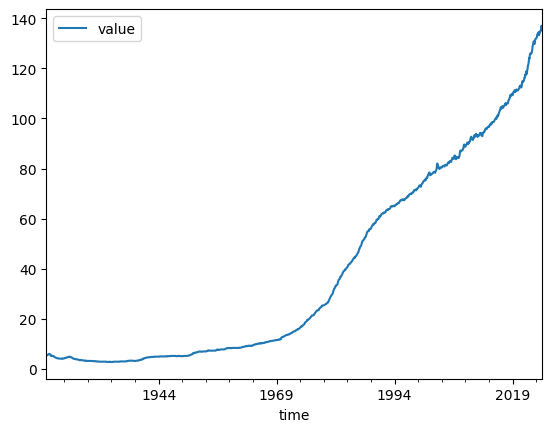

In [89]:
df.plot()

In [90]:
df['value'] = df['value'].pct_change() * 100
df = df.dropna()

In [91]:
df.describe()

,value
count,1261.000000
mean,0.265825
std,0.953099
min,-5.263158
25%,0.000000
50%,0.000000
75%,0.571429
max,8.108108


Post 2005 for mer accuracy

In [92]:
df_2005 = df[df.index > '2005-01-01']

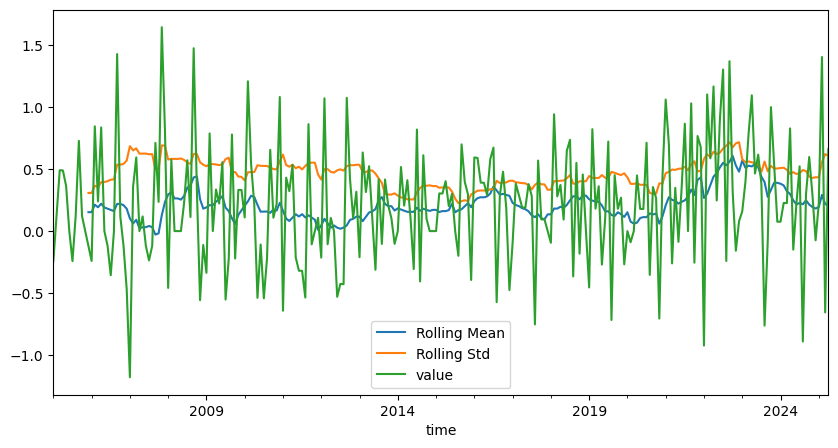

In [93]:
time_series = df_2005['value']
time_series.rolling(window=12).mean().plot(label='Rolling Mean')
time_series.rolling(window=12).std().plot(label='Rolling Std')
time_series.plot(figsize=(10,5))
plt.legend()
plt.show()

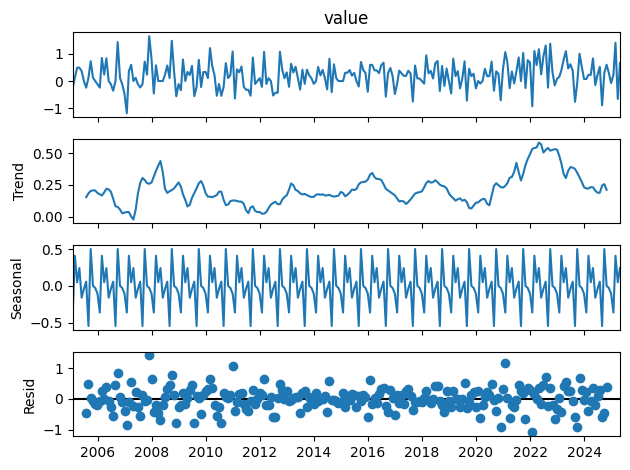

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series)
fig = decomp.plot()

In [95]:
# check if inflation series is stationary
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(time_series):
    result = adfuller(time_series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)

    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(df_2005['value'])

1. ADF:  -2.8292357924076077
2. P-value:  0.054217470066624716
3. Num of Lags:  11
4. Num of Observations:  232
5. Critial Values:
	 1% :  -3.458854867412691
	 5% :  -2.8740800599399323
	 10% :  -2.573453223097503

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


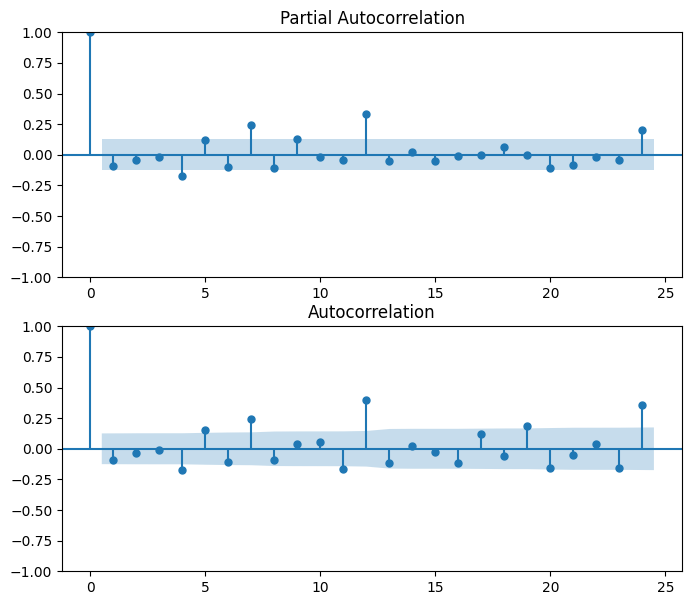

In [96]:
# plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(df_2005, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(df_2005, ax=ax2)
plt.show()

In [97]:
# p=1, d=1, q=0
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df_2005['value'], order=(1,1,0), freq='M')
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:595: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = to_offset(freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  244
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -219.372
Date:                Tue, 13 May 2025   AIC                            442.745
Time:                        08:29:24   BIC                            449.731
Sample:                    01-31-2005   HQIC                           445.559
                         - 04-30-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5293      0.056     -9.471      0.000      -0.639      -0.420
sigma2         0.3557      0.030     12.000      0.000       0.298       0.414
===================================================================================
Ljung-Box (L1) (Q):                   8.67   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.00   Prob(JB):                         0.44
Heteroskedasticity (H):               1.07   Skew:                            -0.01
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
forecast = model_fit.predict(start=0, end=len(df_2005) - 1, typ='levels', dynamic=False)

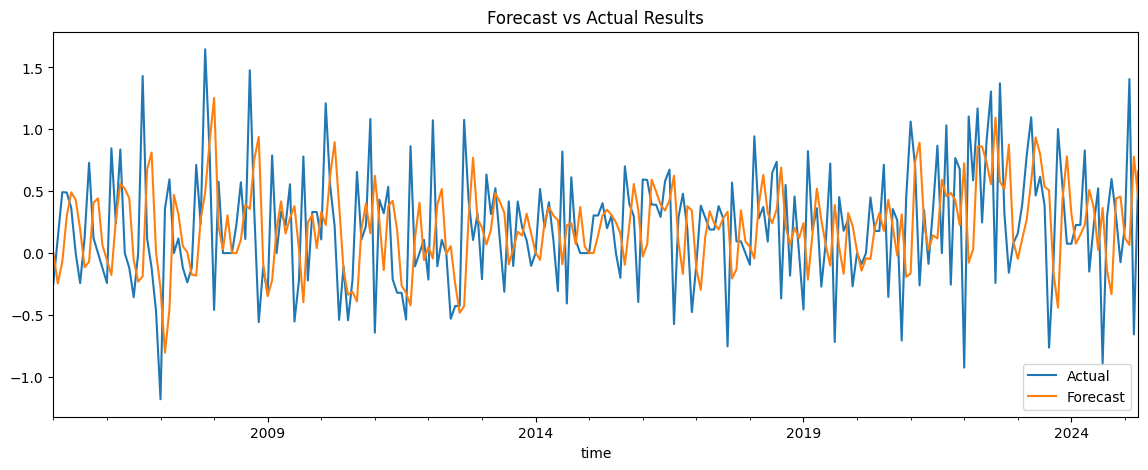

In [99]:
# plot results
df_2005['value'].plot(legend=True, label='Actual', figsize=(14,5))
forecast.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

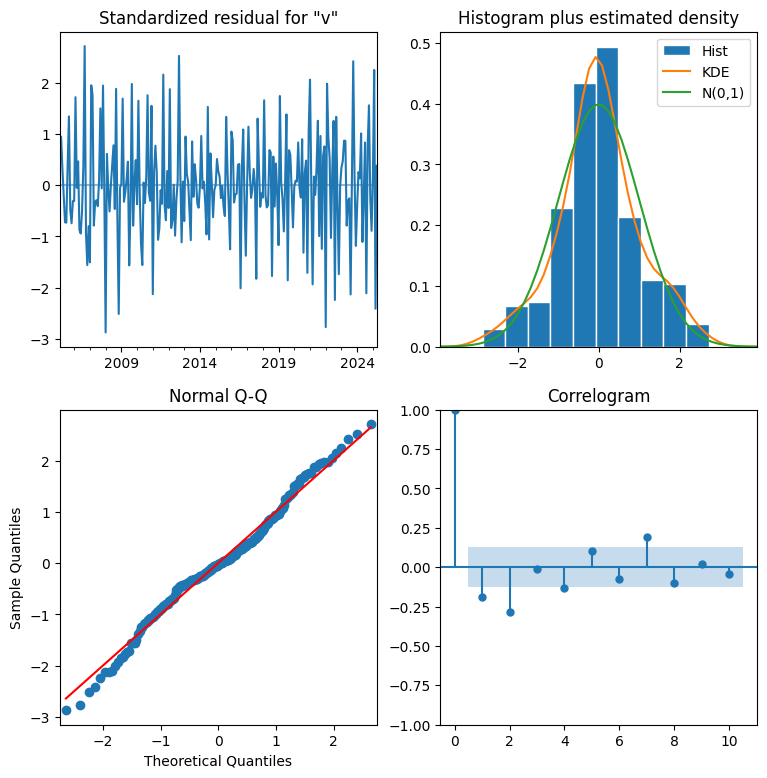

In [100]:
# diagnostic plots for standardized residuals of one endogenous variable
model_fit.plot_diagnostics(figsize=(9,9))
plt.show()

In [101]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(forecast, df_2005['value'])
rmse

0.3546359726723901

In [102]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(forecast, df_2005['value'])
mae

0.44521302324472695

In [103]:
# predict values
forecast_future = model_fit.predict(start=0, end=len(df_2005) + 4, dynamic=False)

In [104]:
# display forecasted values
forecast_future.tail()

,predicted_mean
2025-05-31,-0.036504
2025-06-30,0.332860
2025-07-31,0.137341
2025-08-31,0.240837
2025-09-30,0.186053


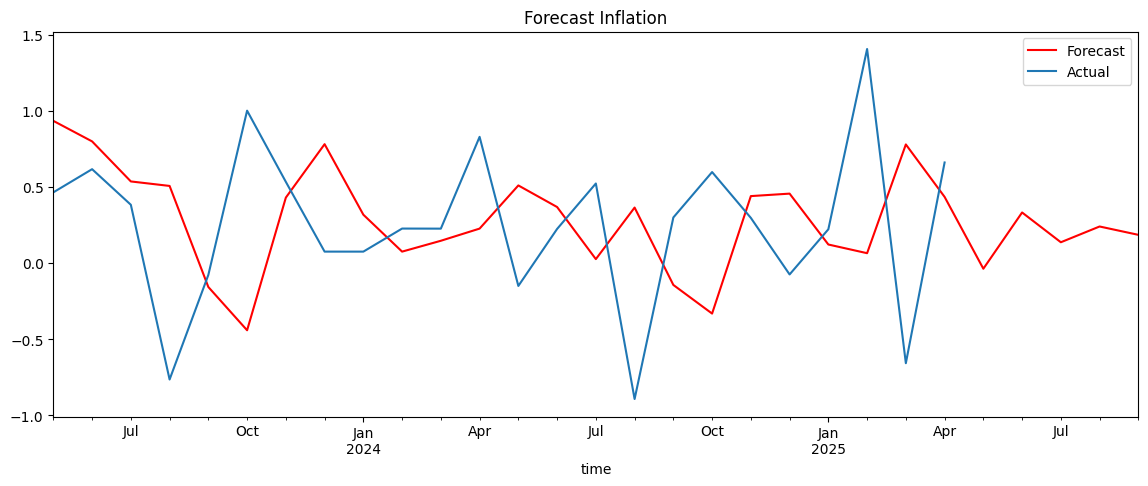

In [105]:
# final plot
forecast_future.iloc[220:].plot(legend=True, label='Forecast', figsize=(14,5), color='red')
df_2005['value'].iloc[220:].plot(legend=True, label='Actual')
plt.title('Forecast Inflation')
plt.show()

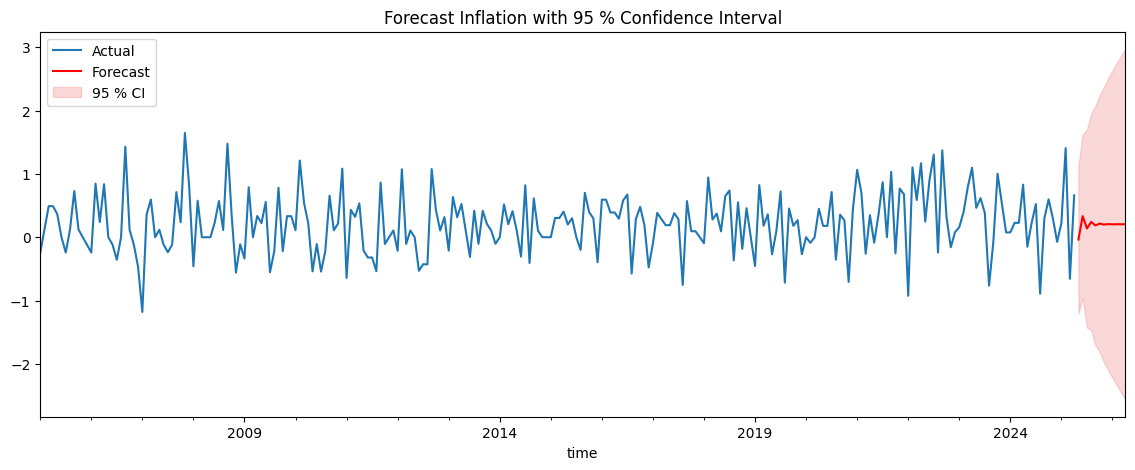

In [106]:
n_steps = 12                                  # antall perioder frem
pred_obj = model_fit.get_forecast(steps=n_steps)
forecast    = pred_obj.predicted_mean        # punktprognose
conf_int_df = pred_obj.conf_int()            # 'lower value', 'upper value'


ax = df_2005['value'].plot(label='Actual', figsize=(14, 5))

# 3. prognosen
forecast.plot(ax=ax, label='Forecast', color='red')

# Fyll smellom nedre og øvre grense
ax.fill_between(
    conf_int_df.index,
    conf_int_df.iloc[:, 0],                 # første kolonne = nedre 95 %-grense
    conf_int_df.iloc[:, 1],                  # andre kolonne = øvre 95 %-grense
    color='lightcoral', alpha=0.3, label='95 % CI'
)


ax.set_title('Forecast Inflation with 95 % Confidence Interval')
ax.legend()
plt.show()

## GARCH

In [107]:
%pip install arch

In [108]:
from arch import arch_model
# Define the inflation rate series (already in % and stationary)
y = df_2005['value']  # pandas Series indexed by date

# Set up GARCH(1,1) model with no ARMA terms in mean
model = arch_model(y, mean='Zero', vol='GARCH', p=1, q=1)

# Alternatively, to include a constant mean term (no AR terms):
# model = arch_model(y, mean='Constant', vol='GARCH', p=1, q=1)

In [109]:
# Fit the GARCH(1,1) model to the data
res = model.fit(update_freq=5)  # update_freq=5 prints iteration progress

# Output the estimation results
print(res.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 185.03214069535312
Optimization terminated successfully    (Exit mode 0)
            Current function value: 184.97225034800914
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  value   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -184.972
Distribution:                  Normal   AIC:                           375.945
Method:            Maximum Likelihood   BIC:                           386.436
                                        No. Observations:                  244
Date:                Tue, May 13 2025   Df Residuals:                      244
Time:                        08:29:34   Df Model:                            0
        

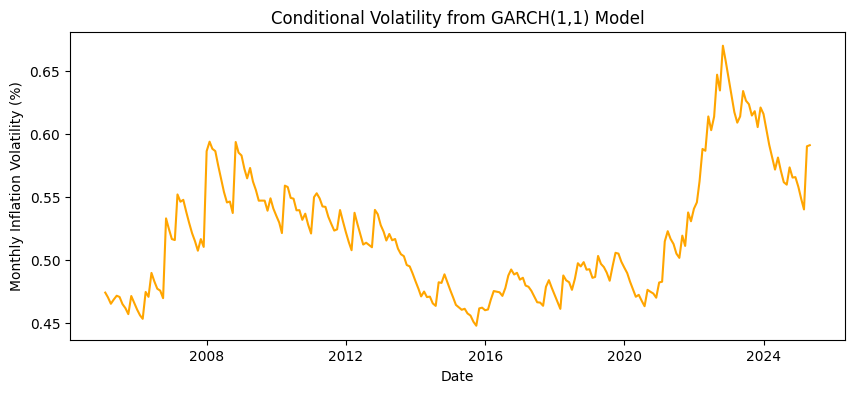

In [110]:
# Extract conditional volatility (standard deviation) from the fitted model
cond_vol = res.conditional_volatility

# Plot the conditional volatility
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(cond_vol, color='orange')
plt.title('Conditional Volatility from GARCH(1,1) Model')
plt.ylabel('Monthly Inflation Volatility (%)')
plt.xlabel('Date')
plt.show()